In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms.functional as TF
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance, entropy
from scipy.spatial.distance import jensenshannon
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)



Using device: cuda


State of Data Collection for Cifar-10 and Gray scaled Cifar-10

In [ ]:

batch_size = 256
data_root = './data'

transform_color = transforms.Compose([
    transforms.ToTensor()
])

transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_color = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_color)
train_gray  = datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_gray)

loader_color = DataLoader(train_color, batch_size=batch_size, shuffle=False, num_workers=2)
loader_gray  = DataLoader(train_gray,  batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_color.classes
print("Classes:", classes)


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Exploratory Data Analysis (EDA)

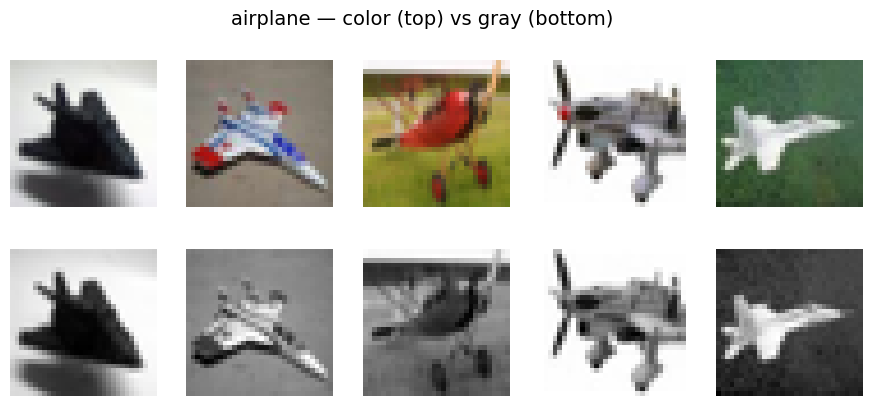

In [ ]:
def show_class_samples(ds_color, ds_gray, class_idx, n=5):
    fig, axes = plt.subplots(2, n, figsize=(n*2.2, 4.5))
    shown_c = 0
    shown_g = 0
    #renkli
    for img, label in ds_color:
        if label == class_idx:
            axes[0, shown_c].imshow(img.permute(1,2,0).numpy())
            axes[0, shown_c].axis('off')
            shown_c += 1
            if shown_c == n: break
    #gray
    for img, label in ds_gray:
        if label == class_idx:
            arr = img.squeeze().numpy()
            axes[1, shown_g].imshow(arr, cmap='gray')
            axes[1, shown_g].axis('off')
            shown_g += 1
            if shown_g == n: break
    plt.suptitle(f"{classes[class_idx]} — color (top) vs gray (bottom)", fontsize=14)
    plt.show()

show_class_samples(train_color, train_gray, class_idx=0, n=5)


Class Distribution

In [ ]:
def compute_mean_std(loader):
    channel_sum = 0.
    channel_sum_sq = 0.
    nb_samples = 0
    for data, _ in loader:
        data = data.float()
        nb = data.size(0)
        channel_sum += data.view(nb, data.size(1), -1).mean(2).sum(0)
        channel_sum_sq += (data.view(nb, data.size(1), -1)**2).mean(2).sum(0)
        nb_samples += nb
    mean = channel_sum / nb_samples
    sq_mean = channel_sum_sq / nb_samples
    std = torch.sqrt(sq_mean - mean**2)
    return mean.numpy(), std.numpy()

mean_color, std_color = compute_mean_std(loader_color)
mean_gray, std_gray = compute_mean_std(loader_gray)
print("Color mean:", mean_color, "std:", std_color)
print("Gray mean:", mean_gray, "std:", std_gray)

def class_mean_brightness(ds_gray):
    sums = defaultdict(float)
    counts = defaultdict(int)
    for img, label in ds_gray:
        vals = img.view(-1).numpy()
        sums[label] += vals.mean()
        counts[label] += 1
    return {classes[k]: sums[k]/counts[k] for k in sorted(sums.keys())}

class_brightness = class_mean_brightness(train_gray)
print("Class mean brightness (gray):", class_brightness)


Color mean: [0.49139956 0.48215848 0.44653094] std: [0.2470325  0.24348502 0.26158777]
Gray mean: [0.48086125] std: [0.23919082]
Class mean brightness (gray): {'airplane': np.float32(0.55322385), 'automobile': np.float32(0.45867422), 'bird': np.float32(0.48312837), 'cat': np.float32(0.46343452), 'deer': np.float32(0.45719713), 'dog': np.float32(0.4697053), 'frog': np.float32(0.43723813), 'horse': np.float32(0.47929052), 'ship': np.float32(0.51822287), 'truck': np.float32(0.4884981)}


Histograms

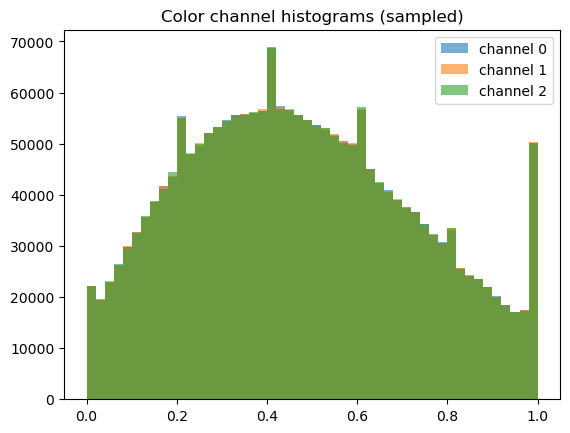

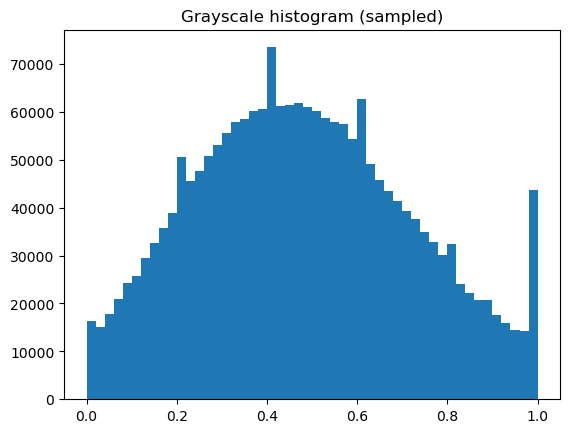

In [ ]:
def plot_color_histograms(ds_color, n_samples=2000):
    pix = []
    cnt = 0
    for img, _ in ds_color:
        pix.append(img.numpy())
        cnt += 1
        if cnt >= n_samples: break
    pix = np.stack(pix)
    N, C, H, W = pix.shape
    pix = pix.reshape(N*C*H*W//C, C)
    for ch in range(C):
        flat = pix[...,ch].ravel()
        plt.hist(flat, bins=50, alpha=0.6, label=f'channel {ch}')
    plt.title("Color channel histograms (sampled)")
    plt.legend()
    plt.show()

def plot_gray_histogram(ds_gray, n_samples=2000):
    pix = []
    cnt = 0
    for img, _ in ds_gray:
        pix.append(img.numpy())
        cnt += 1
        if cnt >= n_samples: break
    flat = np.concatenate([p.ravel() for p in pix])
    plt.hist(flat, bins=50)
    plt.title("Grayscale histogram (sampled)")
    plt.show()

plot_color_histograms(train_color)
plot_gray_histogram(train_gray)


Piksel İstatistikleri

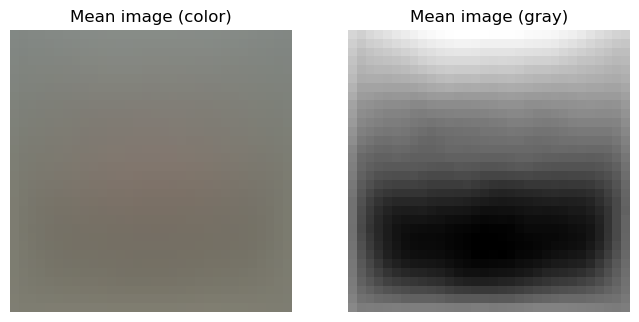

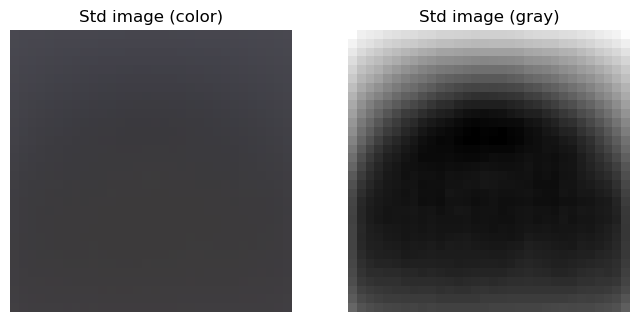

In [ ]:
def mean_std_image(loader, is_color=True):
    sum_img = None
    sum_sq = None
    n = 0
    for img, _ in loader:
        img = img.float()
        if sum_img is None:
            sum_img = torch.zeros_like(img[0])
            sum_sq = torch.zeros_like(img[0])
        for i in range(img.size(0)):
            sum_img += img[i]
            sum_sq += img[i]**2
            n += 1
    mean = sum_img / n
    std = torch.sqrt(sum_sq / n - mean**2)
    return mean.numpy(), std.numpy()

mean_img_c, std_img_c = mean_std_image(loader_color, is_color=True)
mean_img_g, std_img_g = mean_std_image(loader_gray, is_color=False)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.clip(mean_img_c.transpose(1,2,0), 0, 1))
plt.title("Mean image (color)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.clip(mean_img_g.squeeze(), 0, 1), cmap='gray')
plt.title("Mean image (gray)")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.clip(std_img_c.transpose(1,2,0), 0, 1))
plt.title("Std image (color)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.clip(std_img_g.squeeze(), 0, 1), cmap='gray')
plt.title("Std image (gray)")
plt.axis('off')
plt.show()


Domain Difference Measure

In [ ]:
def compute_class_brightness_lists(ds_color, ds_gray, max_per_class=500):
    col_vals = defaultdict(list)
    gray_vals = defaultdict(list)
    #renkli
    for img, lab in ds_color:
        if len(col_vals[lab]) < max_per_class:
            arr = img.numpy()
            if arr.shape[0] == 3:
                lum = 0.299*arr[0] + 0.587*arr[1] + 0.114*arr[2]
            else:
                lum = arr[0]
            col_vals[lab].append(lum.mean())
    #gray
    for img, lab in ds_gray:
        if len(gray_vals[lab]) < max_per_class:
            arr = img.numpy()
            if arr.ndim == 3 and arr.shape[0] == 1:
                lum = arr[0]
            else:
                lum = 0.299*arr[0] + 0.587*arr[1] + 0.114*arr[2]
            gray_vals[lab].append(lum.mean())
    return col_vals, gray_vals

col_vals, gray_vals = compute_class_brightness_lists(train_color, train_gray, max_per_class=500)

for cls in sorted(col_vals.keys()):
    a = np.array(col_vals[cls])
    b = np.array(gray_vals[cls])
    if len(a) < 30 or len(b) < 30:
        print(f"{classes[cls]}: not enough samples")
        continue
    ks_stat, ks_p = ks_2samp(a, b)
    wd = wasserstein_distance(a, b)
    print(f"{classes[cls]}: KS-stat={ks_stat:.4f}, KS-p={ks_p:.3e}, Wasserstein={wd:.4f}, mean_diff={a.mean()-b.mean():.4f}")


airplane: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0001, mean_diff=-0.0000
automobile: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=0.0000
bird: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
cat: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
deer: KS-stat=0.0060, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
dog: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
frog: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=0.0000
horse: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
ship: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000
truck: KS-stat=0.0040, KS-p=1.000e+00, Wasserstein=0.0000, mean_diff=-0.0000


c:\ProgramData\anaconda3\envs\torch\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
